# Deep Learning Sentiment Analysis (Improved Notebook)

This notebook contains the deep learning portion of the assignment. It:
- Loads the Twitter training/validation dataset
- Performs EDA
- Preprocesses text
- Builds deep learning models (BiLSTM, CNN, TF-IDF Dense)
- Runs experiments and evaluates results

In [1]:
# Imports
import os
import re
import html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

TF_AVAILABLE = True
try:
    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
    from tensorflow.keras.optimizers import Adam, RMSprop
    from tensorflow.keras.callbacks import EarlyStopping
except ImportError:
    TF_AVAILABLE = False
    print('⚠️ TensorFlow not installed in this environment. Training will be skipped.')

In [2]:
# Load dataset with proper column names
cols = ["id", "entity", "sentiment", "text"]
TRAIN_PATH = '../Datasets/twitter_training.csv'
VALID_PATH = '../Datasets/twitter_validation.csv'

train_df = pd.read_csv(TRAIN_PATH, header=None, names=cols)
valid_df = pd.read_csv(VALID_PATH, header=None, names=cols)

print(train_df.head())

     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [3]:
# Detect label/text columns safely
TEXT_COL = "text"
LABEL_COL = "sentiment"

print("Using text column:", TEXT_COL)
print("Using label column:", LABEL_COL)

Using text column: text
Using label column: sentiment


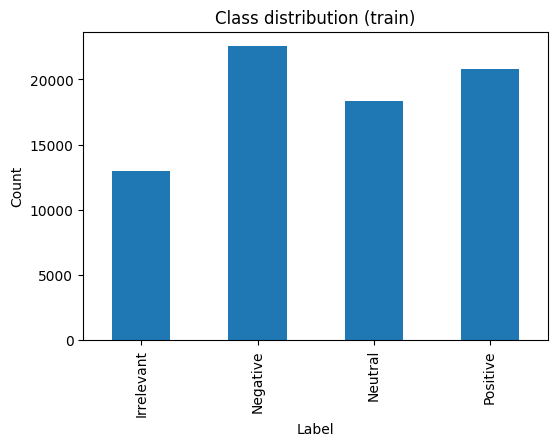

In [4]:
# EDA: Class distribution
class_counts = train_df[LABEL_COL].value_counts().sort_index()
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar')
plt.title('Class distribution (train)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

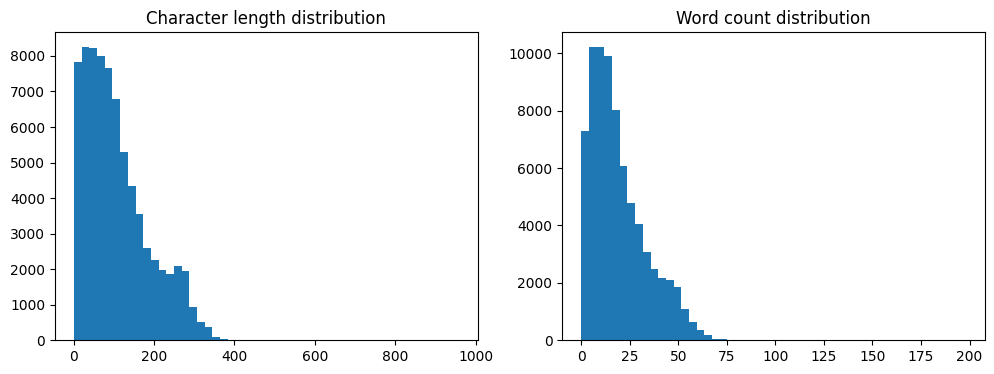

In [5]:
# EDA: Review length distributions
train_df['char_len'] = train_df[TEXT_COL].astype(str).apply(len)
train_df['word_len'] = train_df[TEXT_COL].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(train_df['char_len'], bins=50)
plt.title('Character length distribution')
plt.subplot(1,2,2)
plt.hist(train_df['word_len'], bins=50)
plt.title('Word count distribution')
plt.show()

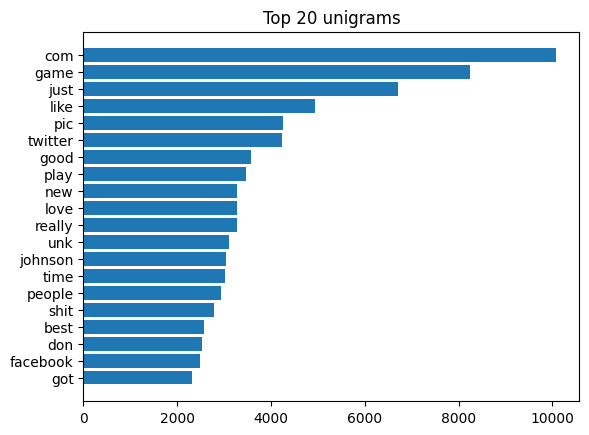

In [6]:
# EDA: Top unigrams
cv = CountVectorizer(stop_words='english', max_features=50)
cv.fit(train_df[TEXT_COL].astype(str))
uni = cv.transform(train_df[TEXT_COL].astype(str))
uni_sum = np.array(uni.sum(axis=0)).flatten()
words = cv.get_feature_names_out()
top_idx = np.argsort(uni_sum)[-20:][::-1]
plt.barh(np.arange(len(top_idx)), uni_sum[top_idx][::-1])
plt.yticks(np.arange(len(top_idx)), words[top_idx][::-1])
plt.title('Top 20 unigrams')
plt.show()

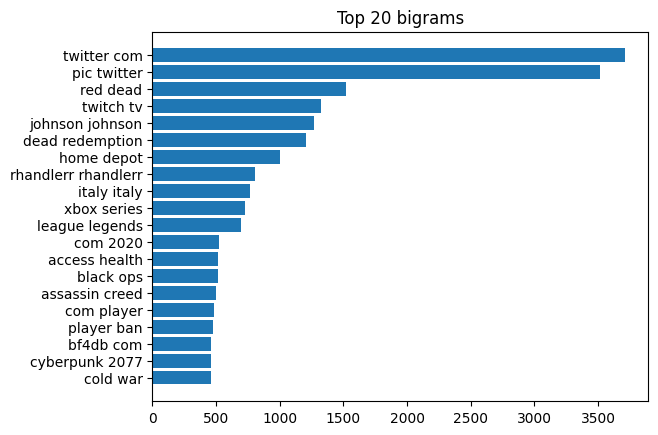

In [7]:
# EDA: Top bigrams
cv_bigram = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=50)
cv_bigram.fit(train_df[TEXT_COL].astype(str))
bi = cv_bigram.transform(train_df[TEXT_COL].astype(str))
bi_sum = np.array(bi.sum(axis=0)).flatten()
bi_words = cv_bigram.get_feature_names_out()
topb_idx = np.argsort(bi_sum)[-20:][::-1]
plt.barh(np.arange(len(topb_idx)), bi_sum[topb_idx][::-1])
plt.yticks(np.arange(len(topb_idx)), bi_words[topb_idx][::-1])
plt.title('Top 20 bigrams')
plt.show()

In [8]:
# Preprocessing
STOPWORDS = set(ENGLISH_STOP_WORDS)

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = html.unescape(s)
    s = re.sub(r'http\S+|www\S+', ' ', s)
    s = re.sub(r'@\w+', ' ', s)
    s = re.sub(r'#', ' ', s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

train_df['clean_text'] = train_df[TEXT_COL].astype(str).apply(clean_text)
valid_df['clean_text'] = valid_df[TEXT_COL].astype(str).apply(clean_text)

In [9]:
# TF-IDF representation
TFIDF_MAX_FEATURES = 20000
tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english')
X_train_tfidf = tfidf.fit_transform(train_df['clean_text']).toarray()
X_valid_tfidf = tfidf.transform(valid_df['clean_text']).toarray()

# Label encoding
le = LabelEncoder()
Y_train = le.fit_transform(train_df[LABEL_COL])
Y_valid = le.transform(valid_df[LABEL_COL])
print('Classes:', le.classes_)

Classes: ['Irrelevant' 'Negative' 'Neutral' 'Positive']


In [10]:
# Tokenizer and sequences (if TF available)
MAX_NUM_WORDS = 20000
MAX_SEQ_LEN = 100
EMBED_DIM = 100

if TF_AVAILABLE:
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_df['clean_text'])
    X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
    X_valid_seq = tokenizer.texts_to_sequences(valid_df['clean_text'])
    X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN)
    X_valid_seq = pad_sequences(X_valid_seq, maxlen=MAX_SEQ_LEN)

In [12]:
# Model definitions
if TF_AVAILABLE:
    def build_lstm_model(vocab_size):
        model = Sequential([
            Embedding(vocab_size, EMBED_DIM, input_length=MAX_SEQ_LEN),
            Bidirectional(LSTM(64)),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        return model

    def build_cnn_model(vocab_size):
        model = Sequential([
            Embedding(vocab_size, EMBED_DIM, input_length=MAX_SEQ_LEN),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        return model

In [15]:
# Experiments grid
experiments = []
experiment_grid = [
    {'model_type':'lstm','lr':1e-3,'batch_size':64,'optimizer':'adam','epochs':5},
    {'model_type':'cnn','lr':1e-3,'batch_size':64,'optimizer':'rmsprop','epochs':5},
    {'model_type':'tfidf_dense','lr':1e-3,'batch_size':64,'optimizer':'adam','epochs':5}
]

# Training loop placeholder (requires TF)

In [16]:
# Evaluation helpers
def plot_history(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion(cm, labels=None):
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap=plt.cm.Blues)
    plt.show()